In [1]:
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import lightgbm as lgb
from IPython.core.debugger import set_trace

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
import os
from pathlib import Path
import glob
import regex
import dill
import gzip
import toolz, itertools, more_itertools
from collections import Counter, OrderedDict

In [6]:
import optuna
import sklearn

In [7]:
import math
import pandas as pd 
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTETomek
import statistics
import shap
np.random.seed(42)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

## DATA directory
Note: Please change the DIR path accordingly

In [8]:
DIR = Path(r'C:\Users\Abhij\OneDrive\Documents\GitHub\DNA-structure-prediction')
assert DIR.exists()
DATA = DIR/"data"

## Helper Functions to read pickled data

In [9]:
def make_dirs(*, name: str) -> ():
    try:
        _file = DIR / "data"
        os.mkdir(_file / name)
    except FileExistsError:
        print("Dir exists")


def pkl_it(dataframe, filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "wb") as fh:
        dill.dump(dataframe, fh)
    return


def unpkl_it(filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "rb") as fh:
        return dill.load(fh)

make_dirs(name="results")
make_dirs(name="pkl")

Dir exists
Dir exists


## A flexible helper Class for running different ML algorithms  
It automatically chooses the best threshold for classification by locating the arg_max (index) of the best F-score  

In [10]:
import logging
from collections import defaultdict
logging.basicConfig(filename=DATA/'results.log', level=logging.INFO)

# A flexible helper Class for running different ML algorithms
# It automatically chooses the best threshold for classification by locating the arg_max (index) of the best F-score

class Call_Plot():
    
    def __init__(self, sklearn_model=False, model_name="LGBM", repeated_k_fold=False):
        plt.close()
        self.model_name = model_name
        self.fig, self.ax = plt.subplots()
        self.ax.plot([0,1], [0,1], linestyle='--', label='Random choice')
        self.ax.set_xlabel('False Positive Rate', fontsize=12)
        self.ax.set_ylabel('True Positive Rate', fontsize=12)
        
        self.fig2, self.ax2 = plt.subplots()
        self.ax2.set_xlabel('Recall', fontsize=12)
        self.ax2.set_ylabel('Precision', fontsize=12)

        self.tprs = []
        self.aucs = []
        self.mean_fpr = np.linspace(0, 1, 100)
        self.no_skill = []
        self.sklearn_model = sklearn_model
        self.results = defaultdict(list)
        self.repeated_k_fold = repeated_k_fold
        
        
    def Plot(self, data: dict, model, idx):
        if self.sklearn_model:
            y_pred_val = model.predict_proba(data["X_val"])[:,1]
        else:
            y_pred_val = model.predict(data["X_val"])
        
        #Precision-Recall
        precision, recall, thresholds = precision_recall_curve(data["y_val"], y_pred_val)
        no_skill = len(data["y_val"][data["y_val"]==1]) / len(data["y_val"])
        self.no_skill.append(no_skill)
        avg_pr = average_precision_score(data["y_val"], y_pred_val)
        auc_pr = sklearn.metrics.auc(recall, precision)
        if self.repeated_k_fold:
            self.ax2.plot(recall, precision, marker='.', label=f'Run {(idx)//5+1} Test Fold{(idx)%5+1}: AUC PR={auc_pr:.2f}')
        else:
            self.ax2.plot(recall, precision, marker='.', label=f'Test Fold{(idx)+1}: AUC PR={auc_pr:.2f}')
        
        # convert to f score
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix_pr = np.argmax(fscore)
        self.ax2.scatter(recall[ix_pr], precision[ix_pr], marker='o', color='black')
        
        Accuracy = sklearn.metrics.accuracy_score(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        target_names = ['B-DNA', 'A-DNA']
        print(classification_report(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0), target_names=target_names))
        F1 = sklearn.metrics.f1_score(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        MCC = sklearn.metrics.matthews_corrcoef(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        cohen_kappa_score = sklearn.metrics.cohen_kappa_score(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        logging.info(f'Fold {idx + 1}: Average PR: {avg_pr:.2f} ')
        logging.info(f'Fold {idx + 1}: AUC PR: {auc_pr:.2f} ')
        logging.info(f'Fold {idx + 1}: Best Threshold_f-score={thresholds[ix_pr]:.2f}, F-Score={fscore[ix_pr]}')
        logging.info(f'Fold {idx + 1}: Accuracy: {Accuracy:.2f}')
        logging.info(f'Fold {idx + 1}: F1: {F1:.2f}')
        logging.info(f'Fold {idx + 1}: MCC: {MCC:.2f}')
        
        #ROC-AUC
        fpr, tpr, thresholds_auc = roc_curve(data["y_val"], y_pred_val)
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        if self.repeated_k_fold:
            self.ax.plot(fpr, tpr, marker='.',
                     label=f'Run {(idx)//5+1} Test Fold{(idx)%5+1}: AUC={sklearn.metrics.auc(fpr, tpr):.2f}')
        else:
            self.ax.plot(fpr, tpr, marker='.',
                     label=f'Test Fold{(idx)+1}: AUC={sklearn.metrics.auc(fpr, tpr):.2f}')
        self.ax.scatter(fpr[ix], tpr[ix], marker='o', color='black')
        # axis labels
        self.ax.legend(loc="lower left")
        # Mean plot
        interp_tpr = np.interp(self.mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        self.tprs.append(interp_tpr)
        self.aucs.append(gmeans[ix])
        
        logging.info(f'Fold {idx + 1}: ROC-AUC: {sklearn.metrics.auc(fpr, tpr):.2f}')
        logging.info(f'Fold {idx + 1}: Best Threshold_ROC={thresholds_auc[ix]:.2f}, G-Mean_ROC={gmeans[ix]:.2f}')
        print("Average PR: ", avg_pr )
        print("AUC PR: ", auc_pr)
        print('Best Threshold_f-score=%f, F-Score=%.3f' % (thresholds[ix_pr], fscore[ix_pr]))
        print("AUC: ", sklearn.metrics.auc(fpr, tpr))
        print('Best Threshold_ROC=%f, G-Mean_ROC=%.3f' % (thresholds_auc[ix], gmeans[ix]))
        print("Accuracy: ", Accuracy )
        print("F1: ", F1 )
        print("MCC: ", MCC )
        self.results["Average PR"].append(avg_pr)
        self.results["AUC PR"].append(auc_pr)
        self.results["ROC AUC"].append(sklearn.metrics.auc(fpr, tpr))
        self.results["Accuracy"].append(Accuracy)
        self.results["F1"].append(F1)
        self.results["MCC"].append(MCC)
        self.results["cohen_kappa_score"].append(cohen_kappa_score)

    
    def post_Plot(self):
        from sklearn.metrics import auc
        mean_tpr = np.mean(self.tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(self.mean_fpr, mean_tpr)
        std_auc = np.std(self.aucs)
        self.ax.plot(self.mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

        std_tpr = np.std(self.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        self.ax.fill_between(self.mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
        self.ax.legend(loc=(0.45, .05),fontsize='medium')
        self.fig.savefig(DIR/"data"/"results"/f"{self.model_name}_AUC_ROC.png", dpi=600)
        no_skill = np.mean(np.array(self.no_skill))
        self.ax2.plot([0,1], [no_skill,no_skill], linestyle='--', label="Random")
        self.ax2.legend(loc=(0.050, .08),fontsize='medium')
        self.fig2.savefig(DIR/"data"/"results"/f"{self.model_name}_AUC_PR.png", dpi=600)
        

## Read curated dataset

In [11]:
curated_data = unpkl_it("curated_dataset")
curated_data

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


In [12]:
#Check if any sequence has duplicate features
curated_data.drop_duplicates(subset=['AA/TT', 'GG/CC', 'AC/GT',
                                          'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC'], keep='last')

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


## Nested Cross-validation

In [13]:
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import RepeatedStratifiedKFold

The function gen_data is a flexible generator that implements outer fold of Nested CV  
Here, we are using 5-fold stratified Nested cross validation (n_splits = 5)  

In [14]:

def gen_data(data: pd.DataFrame, RESAMPLING: bool=False):
    X, y = data.drop(labels="target", axis=1), data["target"]
    sss = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    #sss = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=42)
    for train_index, val_index in sss.split(X, y):
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X.iloc[train_index,:], y.iloc[train_index])
        yield {"X_train": X_resampled if RESAMPLING else X.iloc[train_index,:],
               "y_train": y_resampled if RESAMPLING else y.iloc[train_index],
              "X_val": X.iloc[val_index,:], "y_val": y.iloc[val_index]}

This generator implements inner fold of Nested CV, where we tune hyperparameters.

In [15]:
def gen_data_for_tuningHP(data: dict, RESAMPLING: bool=True):
    
    X, y = data["X_train"], data["y_train"]
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
    for train_index, val_index in sss.split(X, y):
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X.iloc[train_index,:], y.iloc[train_index])
        yield {"X_train": X_resampled if RESAMPLING else X.iloc[train_index,:],
               "y_train": y_resampled if RESAMPLING else y.iloc[train_index],
               "X_val": X.iloc[val_index,:], "y_val": y.iloc[val_index]}
    

## Helper function: train_test_folds_reader

This generator function reads the data from the "train_test_folds" folder and gives the same Train-Test splits
used by us. At each iteration it yields a single split of the data
Alternatively, you can run the `gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING=False)`, which gives the same split provided that you use the same seed.


In [16]:

def train_test_folds_reader(*, folder) -> dict:
    TRAIN_TEST = Path(folder)
    for i in range(5):
        yield {"X_train": pd.read_excel(folder/f"train_fold_{i+1}.xls", index_col=0).drop(labels=["target", "sequence", "item"], axis=1),
               "y_train": pd.read_excel(folder/f"train_fold_{i+1}.xls", index_col=0)["target"],
               "X_val":   pd.read_excel(folder/f"test_fold_{i+1}.xls", index_col=0).drop(labels=["target", "sequence", "item"], axis=1),
               "y_val":   pd.read_excel(folder/f"test_fold_{i+1}.xls", index_col=0)["target"],}

## Read the best LightGBM hyperparameters

In [17]:
best_lgb_params = pd.read_csv(DATA/"tuned_hyperparameters"/"best_lgb_params.csv", index_col=0)

In [18]:
best_lgb_params #contains the best hyperparams 

,objective,seed,metric,verbosity,boosting_type,learning_rate,scale_pos_weight,lambda_l1,lambda_l2,num_leaves,feature_fraction,bagging_fraction,bagging_freq,min_child_samples,num_iterations
Model_1,binary,42,auc,-1,gbdt,0.1,2.147541,0.000011,7.170000e-07,65,0.847751,0.776944,1,2,150
Model_2,binary,42,auc,-1,gbdt,0.1,2.147541,0.000247,2.300000e-05,244,0.511385,0.614197,1,4,150
Model_3,binary,42,auc,-1,gbdt,0.1,2.147541,0.002451,4.810000e-07,63,0.494087,0.904994,1,9,150
Model_4,binary,42,auc,-1,gbdt,0.1,2.147541,0.000007,9.939805e-03,201,0.877167,0.589557,1,12,150
Model_5,binary,42,auc,-1,gbdt,0.1,2.147541,0.000127,1.677127e-01,101,0.480231,0.920670,7,3,150


## Set up LightGBM training

In [19]:
#Class weight factor:
SCALE_POS_WEIGHT = lambda T,P: (100*(T-P)/T) / (100*P/T)

In [20]:
def trainer(data: dict, param_updater: dict):
    train_x, train_y = data["X_train"], data["y_train"]
    dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
    param = {
        "objective": "binary",
        "seed": 42,
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "scale_pos_weight": SCALE_POS_WEIGHT(len(curated_data), curated_data.target.sum()),
    }
    param.update(param_updater)
    model = lgb.train(param, dtrain,
                    num_boost_round=150,
                    verbose_eval=False,
                    )
    return model
    

## Train, Run and evaluate performance of LightGBM using the tuned hyperparameters 
Here, we use the `train_test_folds_reader(folder=DATA/"train_test_folds")` to yield the same split of data as used us. We then use the tuned hyperparameters (best_lgb_params) and convert it into a dictionary. We then train each model and evaluate the performance of each model on each test fold. Note that the `gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING=False)` will give the same split if you use the same seed (42).

<IPython.core.display.Javascript object>


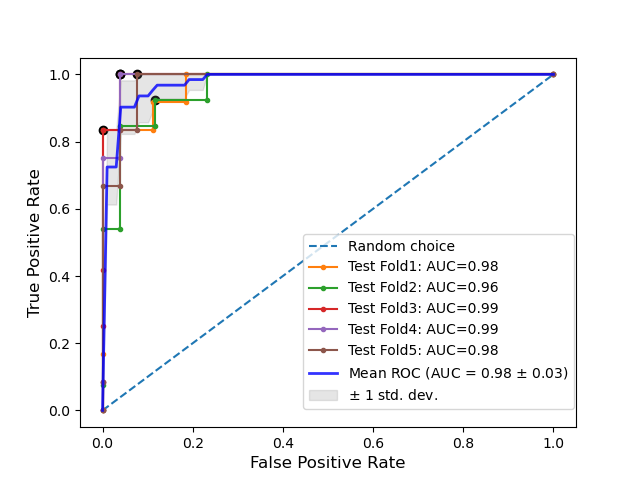

<IPython.core.display.Javascript object>


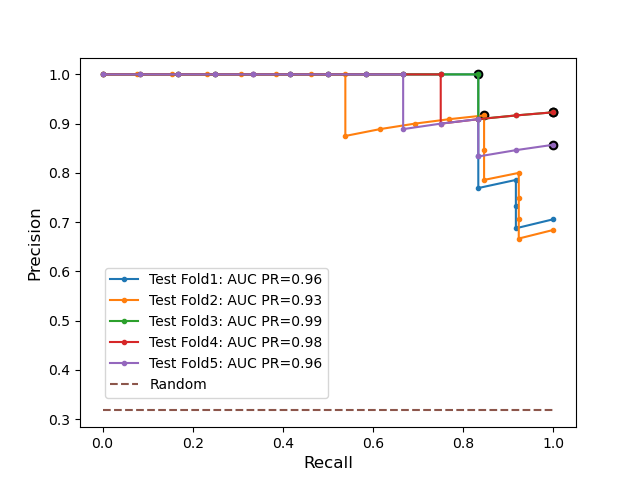

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


              precision    recall  f1-score   support

       B-DNA       0.90      1.00      0.95        27
       A-DNA       1.00      0.75      0.86        12

    accuracy                           0.92        39
   macro avg       0.95      0.88      0.90        39
weighted avg       0.93      0.92      0.92        39

Average PR:  0.9576330532212884
AUC PR:  0.9561803086619263
Best Threshold_f-score=0.587957, F-Score=0.909
AUC:  0.9753086419753088
Best Threshold_ROC=0.587957, G-Mean_ROC=0.913
Accuracy:  0.9230769230769231
F1:  0.8571428571428571
MCC:  0.8215838362577491
              precision    recall  f1-score   support

       B-DNA       0.89      0.96      0.93        26
       A-DNA       0.91      0.77      0.83        13

    accuracy                           0.90        39
   macro avg       0.90      0.87      0.88        39
weighted avg       0.90      0.90      0.90        39

Average PR:  0.9306813069970963
AUC PR:  0.9278545285124231
Best Threshold_f-score=0.8108

Found `num_iterations` in params. Will use it instead of argument


              precision    recall  f1-score   support

       B-DNA       0.96      0.96      0.96        26
       A-DNA       0.92      0.92      0.92        12

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38

Average PR:  0.9866452991452993
AUC PR:  0.9860625485625486
Best Threshold_f-score=0.874021, F-Score=0.960
AUC:  0.9935897435897436
Best Threshold_ROC=0.874021, G-Mean_ROC=0.981
Accuracy:  0.9473684210526315
F1:  0.9166666666666666
MCC:  0.8782051282051282
              precision    recall  f1-score   support

       B-DNA       0.96      0.96      0.96        26
       A-DNA       0.92      0.92      0.92        12

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38

Average PR:  0.9790695415695417
AUC PR:  0.9781080031080033
Best Threshold_f-score=0.2559

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


              precision    recall  f1-score   support

       B-DNA       0.96      0.92      0.94        26
       A-DNA       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.90      0.92      0.91        38
weighted avg       0.92      0.92      0.92        38

Average PR:  0.9593656343656346
AUC PR:  0.9575318200318202
Best Threshold_f-score=0.051672, F-Score=0.923
AUC:  0.9807692307692308
Best Threshold_ROC=0.051672, G-Mean_ROC=0.961
Accuracy:  0.9210526315789473
F1:  0.8799999999999999
MCC:  0.8227773238579393


In [21]:
plt.close()
# *************OUTER*************
plot_Model_LGBM_test = Call_Plot()

for outer_idx, elem in enumerate(train_test_folds_reader(folder=DATA/"train_test_folds")):
    # ***********Feed in the best hyperparams for each model************
    model = trainer(elem, best_lgb_params.T.to_dict()
                    [f"Model_{outer_idx + 1}"])
    plot_Model_LGBM_test.Plot(elem, model, outer_idx)
plot_Model_LGBM_test.post_Plot()

In [22]:
pd.DataFrame(plot_Model_LGBM_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.957633,0.956180,0.975309,0.923077,0.857143,0.821584,0.805970
1,0.930681,0.927855,0.961538,0.897436,0.833333,0.765532,0.760000
2,0.986645,0.986063,0.993590,0.947368,0.916667,0.878205,0.878205
3,0.979070,0.978108,0.990385,0.947368,0.916667,0.878205,0.878205
4,0.959366,0.957532,0.980769,0.921053,0.880000,0.822777,0.821317


In [23]:
pd.DataFrame(plot_Model_LGBM_test.results).mean()

Average PR           0.962679
AUC PR               0.961147
ROC AUC              0.980318
Accuracy             0.927260
F1                   0.880762
MCC                  0.833261
cohen_kappa_score    0.828739
dtype: float64

## Running from scratch - Run and evaluate performance of LightGBM under 5-fold stratified Nested CV
Note: This will take some time to run as we are doing hyperparameter search using TPE in optuna. The objective defines the search space. Pruning is used to stop the unpromising trials. For details refer optuna doc(https://optuna.org/)

In [ ]:
import optuna

import copy


def objective(data: dict, metric: str, trial):

    train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]
    dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
    dvalid = lgb.Dataset(valid_x, label=valid_y, free_raw_data=True)
    watchlist = [dtrain, dvalid]
    param = {
        "objective": "binary",
        "seed": 42,
        "metric": metric,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 100),
        "scale_pos_weight": SCALE_POS_WEIGHT(len(curated_data), curated_data.target.sum()),
    }

    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, metric, valid_name='valid_1')

    model = lgb.train(param, dtrain,
                      num_boost_round=150,
                      valid_sets=watchlist,
                      early_stopping_rounds=15,
                      callbacks=[pruning_callback],
                      verbose_eval=False,
                      )
    y_pred_valid = model.predict(valid_x, num_iteration=model.best_iteration)
    pred_labels = np.rint(y_pred_valid)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(
        valid_y, pred_labels)
    f1 = sklearn.metrics.f1_score(valid_y, pred_labels)
    mcc = sklearn.metrics.matthews_corrcoef(valid_y, pred_labels)

    log = {f'train/{metric}': model.best_score['training'][metric],
           f'valid/{metric}': model.best_score['valid_1'][metric]}
    return log[f'valid/{metric}']


In [ ]:
import collections
Trial = collections.namedtuple("Trial",["value", "parameters"])

In [ ]:
plt.close()
optuna.logging.set_verbosity(optuna.logging.WARNING)
results = []
outer_models = {}
best_models_LGBM = {}

# *************OUTER*************
plot_Model_LGBM = Call_Plot(repeated_k_fold=False)
for outer_idx, elem in enumerate(gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING = False)):
    
    study_dict_LGBM = {}
    # ***********INNER************
    for idx, data_in in enumerate(gen_data_for_tuningHP(elem, RESAMPLING=False)):
        
        study_LGBM = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="maximize")
        study_LGBM.optimize((toolz.curry(objective)(data_in)("auc")), n_trials=200)

        
        trial = study_LGBM.best_trial
        study_dict_LGBM[idx] = Trial(trial.value, trial.params)
    arg_max = max(study_dict_LGBM, key=lambda d: study_dict_LGBM[d].value) #max for AUC
    best_models_LGBM[outer_idx] = trainer(elem, study_dict_LGBM[arg_max].parameters)
    
    plot_Model_LGBM.Plot(elem, best_models_LGBM[outer_idx], outer_idx)
plot_Model_LGBM.post_Plot()


In [ ]:
pd.DataFrame(plot_Model_LGBM_test.results)

In [ ]:
pd.DataFrame(plot_Model_LGBM_test.results).mean()

In [ ]:
####################################################

# LightGBM -> SHAP based explanations(interpretation model)

Here we build an anciliary model for interpreting our main model's prediction.  
We use the model that gives best overall predictive performance on the test set. We then use the training data to interpret what our main model is learning and how its predictive performance depends on the components of feature vectors.  

In [24]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [25]:
outer_fold_data = {} #here we have just stored the data generated from the outer loop
for outer_idx, elem in enumerate(gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING = False)):
    outer_fold_data[outer_idx] = elem

Found `num_iterations` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<IPython.core.display.Javascript object>


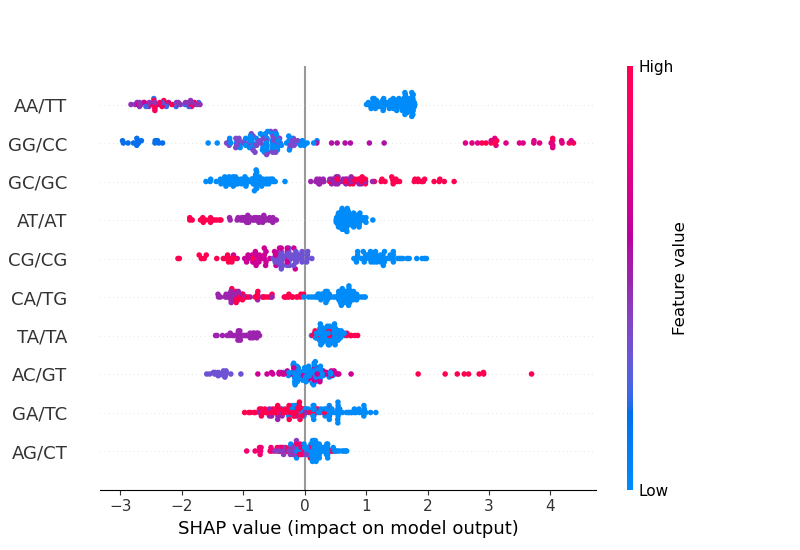

In [26]:
ID = 3 # pick the fold where the model gives best performance 
model = trainer(outer_fold_data[ID], best_lgb_params.T.to_dict()[f"Model_{ID + 1}"]) # rebuild the model with its best hyperparameters
explainer = shap.TreeExplainer(model) 
X = outer_fold_data[ID]["X_train"]
y = outer_fold_data
shap_values = explainer.shap_values(X, y=outer_fold_data[ID]["y_train"])


plt.close()
plt.figure()
shap.summary_plot(shap_values[1], X)


<IPython.core.display.Javascript object>


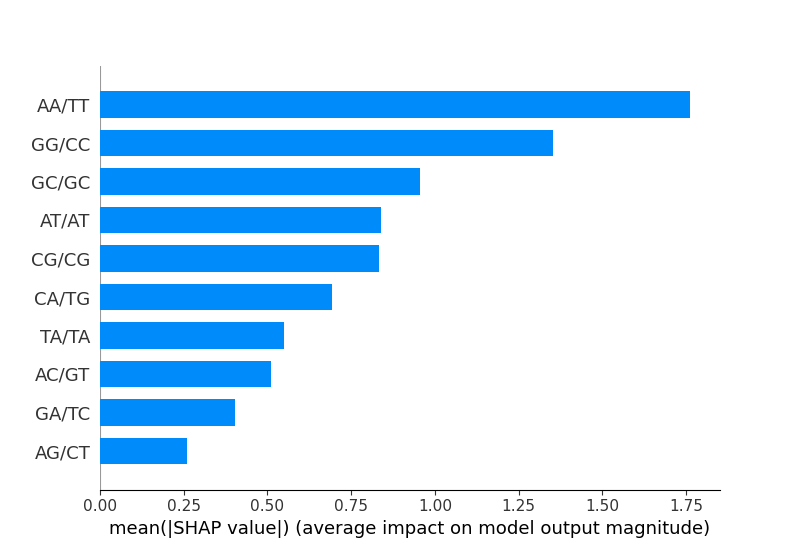

In [27]:
plt.close()
plt.figure()
shap.summary_plot(shap_values[1], X , plot_type="bar")